In [66]:
import numpy as np
from scipy import stats

%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt

import seaborn as sns
import pandas as pd

In [67]:
import nest_asyncio # https://pystan.readthedocs.io/en/latest/faq.html
nest_asyncio.apply()

In [68]:
import stan
import arviz as az # For visualization and loo

We're roughly following this example: https://mc-stan.org/docs/stan-users-guide/summing-out-the-responsibility-parameter.html

We're fitting a mixture of normal models:

There are $K$ types (normal distributions). Data is drawn from type $k$ with probability $\theta_k$. When drawn from type $k$, 

$$
y \sim Normal(\mu_k, \sigma_k)
$$

$\{\theta_k, \mu_k, \sigma_k\}$ are unknown

# Let's generate data from the model, given the parameters

In [69]:
def generate_data_from_mixture(thetas, mus, sigmas, K, N = 500):
    ys = []
    for i in range(N):
        k = np.random.choice(K, p = thetas)
        ys.append(np.random.normal(mus[k], sigmas[k]))
    return {'y': ys, 'K': K, 'N': N}

## Things work well if the mixtures are well separated with a lot of data (maybe, this is still pretty finicky...)

In [159]:
K = 3
thetas = [0.3, 0.3, 0.4]
mus = [0, 2, 4]
sigmas = [0.25, 0.5, 0.75]

In [160]:
stan_data = generate_data_from_mixture(thetas, mus, sigmas, K, N = 3000)

(array([0.07553662, 0.3731327 , 0.32034808, 0.0582451 , 0.02639231,
        0.08736766, 0.19566715, 0.24663162, 0.20476795, 0.13014141,
        0.12286077, 0.17928571, 0.20385787, 0.19475707, 0.14470268,
        0.09100798, 0.04186367, 0.02275199, 0.00546048, 0.00546048]),
 array([-0.71544874, -0.34918048,  0.01708778,  0.38335605,  0.74962431,
         1.11589257,  1.48216084,  1.8484291 ,  2.21469736,  2.58096563,
         2.94723389,  3.31350215,  3.67977042,  4.04603868,  4.41230694,
         4.77857521,  5.14484347,  5.51111173,  5.87738   ,  6.24364826,
         6.60991652]),
 <BarContainer object of 20 artists>)

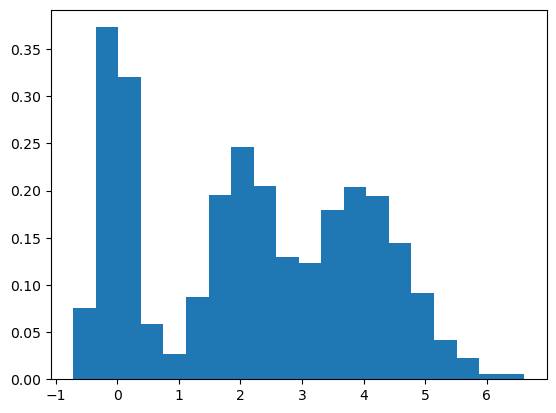

In [161]:
plt.hist(stan_data['y'], bins = 20, density = True)

### Let's fit the model

In [162]:
stan_folder = 'stan_code/'
stan_file = stan_folder + 'mixture_normals.stan'
with open(stan_file) as file:
    model_code = file.read()
print(model_code)

# From following url: https://mc-stan.org/docs/stan-users-guide/summing-out-the-responsibility-parameter.html

data {
  int<lower=1> K;          // number of mixture components
  int<lower=1> N;          // number of data points
  array[N] real y;         // observations
}
parameters {
  simplex[K] theta;          // mixing proportions
  ordered[K] mu;             // locations of mixture components
  vector<lower=0>[K] sigma;  // scales of mixture components
}
model {
  vector[K] log_theta = log(theta);  // cache log calculation
  sigma ~ lognormal(0, 3);
  mu ~ normal(0, 20);
  for (n in 1:N) {
    vector[K] lps = log_theta;
    for (k in 1:K) {
      lps[k] += normal_lpdf(y[n] | mu[k], sigma[k]);
    }
    target += log_sum_exp(lps);
  }
}


In [163]:
compiled_model = stan.build(model_code, data=stan_data, random_seed=1)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_b_pxh092/model_3w6ohvzf.stan', line 1, column 0: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/tmp/httpstan_b_pxh092/model_3w6ohvzf.stan', line 16, column 17: Argument
    20 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [164]:
fit = compiled_model.sample(num_chains=2, num_warmup = 500, num_samples= 1000)

Sampling:   0%
Sampling:   0% (1/3000)
Sampling:   0% (2/3000)
Sampling:   3% (101/3000)
Sampling:   7% (201/3000)
Sampling:  10% (301/3000)
Sampling:  13% (401/3000)
Sampling:  17% (500/3000)
Sampling:  20% (601/3000)
Sampling:  23% (700/3000)
Sampling:  27% (800/3000)
Sampling:  30% (900/3000)
Sampling:  33% (1000/3000)
Sampling:  37% (1100/3000)
Sampling:  40% (1200/3000)
Sampling:  43% (1300/3000)
Sampling:  47% (1400/3000)
Sampling:  50% (1500/3000)
Sampling:  53% (1600/3000)
Sampling:  57% (1700/3000)
Sampling:  60% (1800/3000)
Sampling:  63% (1900/3000)
Sampling:  67% (2000/3000)
Sampling:  67% (2001/3000)
Sampling:  70% (2100/3000)
Sampling:  73% (2200/3000)
Sampling:  77% (2300/3000)
Sampling:  80% (2400/3000)
Sampling:  83% (2500/3000)
Sampling:  87% (2600/3000)
Sampling:  90% (2700/3000)
Sampling:  93% (2800/3000)
Sampling:  97% (2900/3000)
Sampling: 100% (3000/3000)
Sampling: 100% (3000/3000), done.
Messages received during sampling:
  Gradient evaluation took 0.001879 seco

In [165]:
idata = az.from_pystan(posterior=fit, posterior_model=compiled_model
                            )

In [166]:
thetas

[0.3, 0.3, 0.4]

In [167]:
mus

[0, 2, 4]

In [168]:
sigmas

[0.25, 0.5, 0.75]

In [169]:
summary = az.summary(fit)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],0.302,0.010,0.288,0.318,0.001,0.000,650.0,209.0,1.01
theta[1],0.254,0.044,0.197,0.316,0.027,0.024,3.0,12.0,1.90
theta[2],0.444,0.047,0.383,0.502,0.028,0.022,3.0,12.0,1.91
mu[0],-0.006,0.010,-0.023,0.012,0.001,0.001,223.0,200.0,1.03
mu[1],1.934,0.161,1.875,2.034,0.045,0.044,3.0,51.0,1.74
mu[2],3.824,0.155,3.622,4.041,0.097,0.080,3.0,11.0,1.93
sigma[0],0.252,0.007,0.240,0.266,0.000,0.000,358.0,330.0,1.01
sigma[1],0.459,0.054,0.399,0.517,0.014,0.010,3.0,15.0,1.60
sigma[2],0.921,0.115,0.760,1.088,0.078,0.065,3.0,11.0,2.20


In [170]:
def plot_stuff_about_model(idata, stan_data, fit):
    print ('CONVERGENCE CHECKS')
    az.plot_trace(idata)
    plt.show()
    
    az.plot_rank(idata)
    plt.show()
    
    az.plot_autocorr(idata)
    
    # Plot local ESS. This plot, together with the quantile ESS plot, is recommended to check that there are enough samples for all the explored regions of parameter space. Checking local and quantile ESS is particularly relevant when working with HDI intervals as opposed to ESS bulk, which is relevant for point estimates.
    # https://python.arviz.org/en/stable/api/generated/arviz.plot_ess.html  
    az.plot_ess(idata)
    plt.show()
    
    # Plot ESS evolution as the number of samples increase. When the model is converging properly, both lines in this plot should be roughly linear.
    az.plot_ess(idata, kind='evolution')
    plt.show()
    
    print('IS THE MODEL GOOD?')
    az.plot_pair(idata)
    plt.show()

CONVERGENCE CHECKS


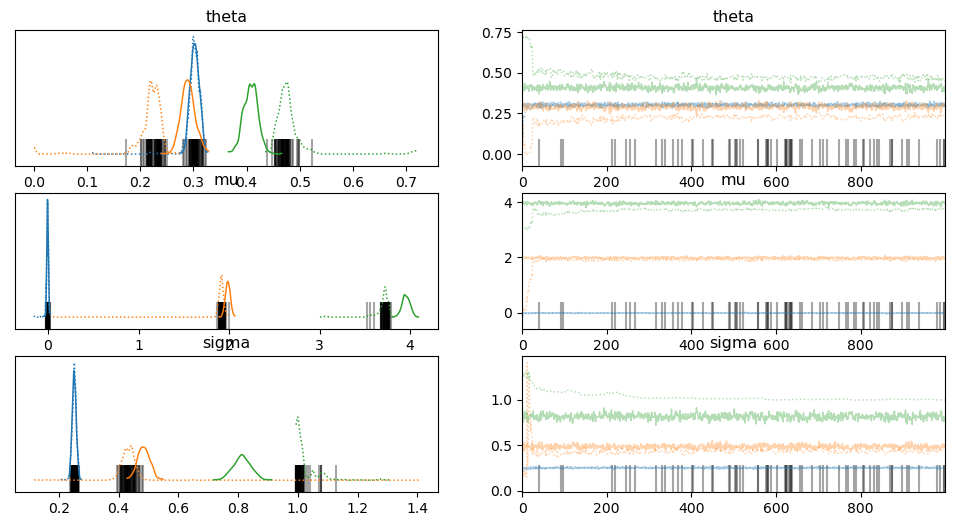

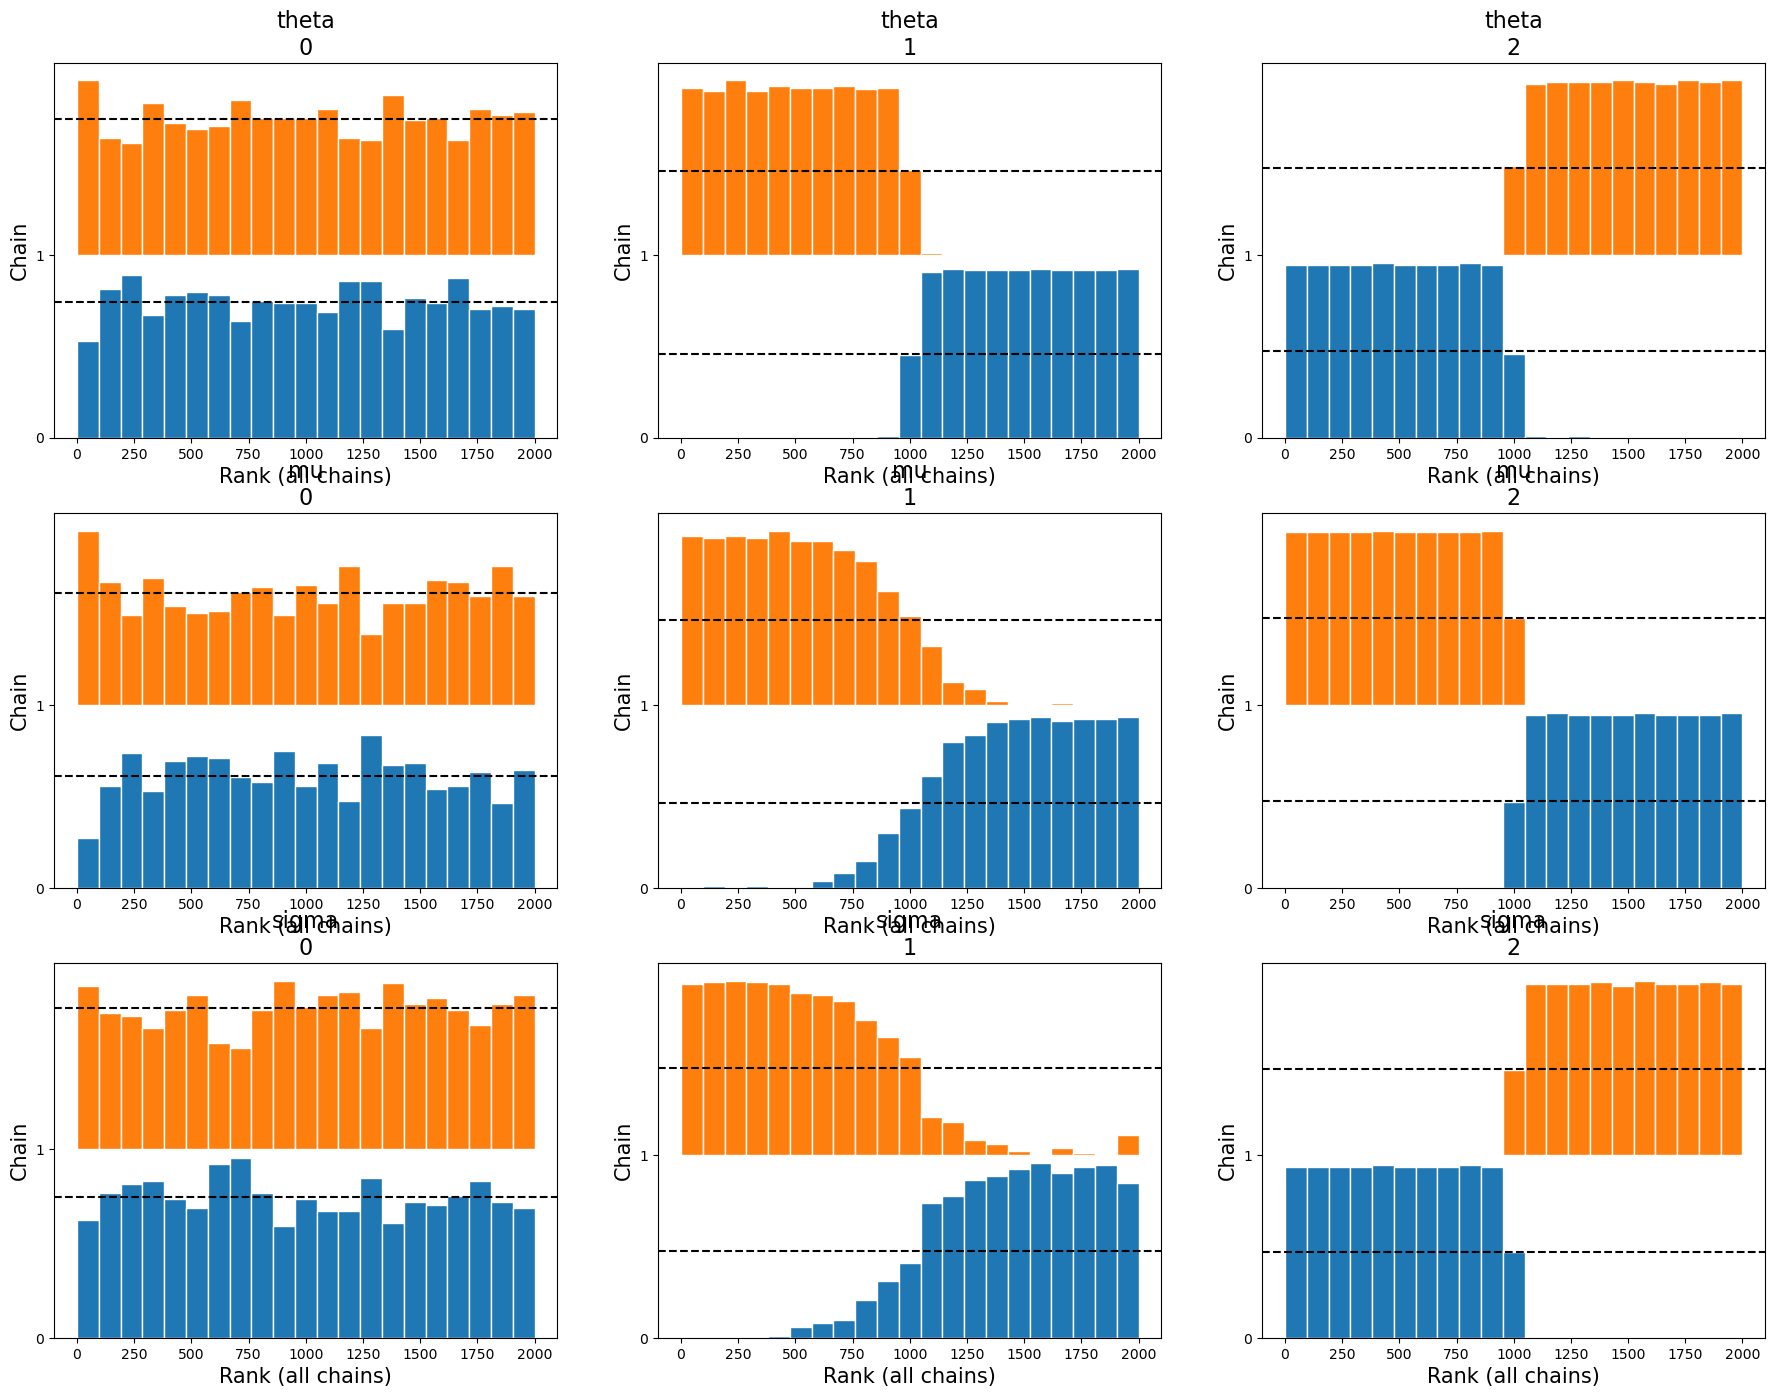

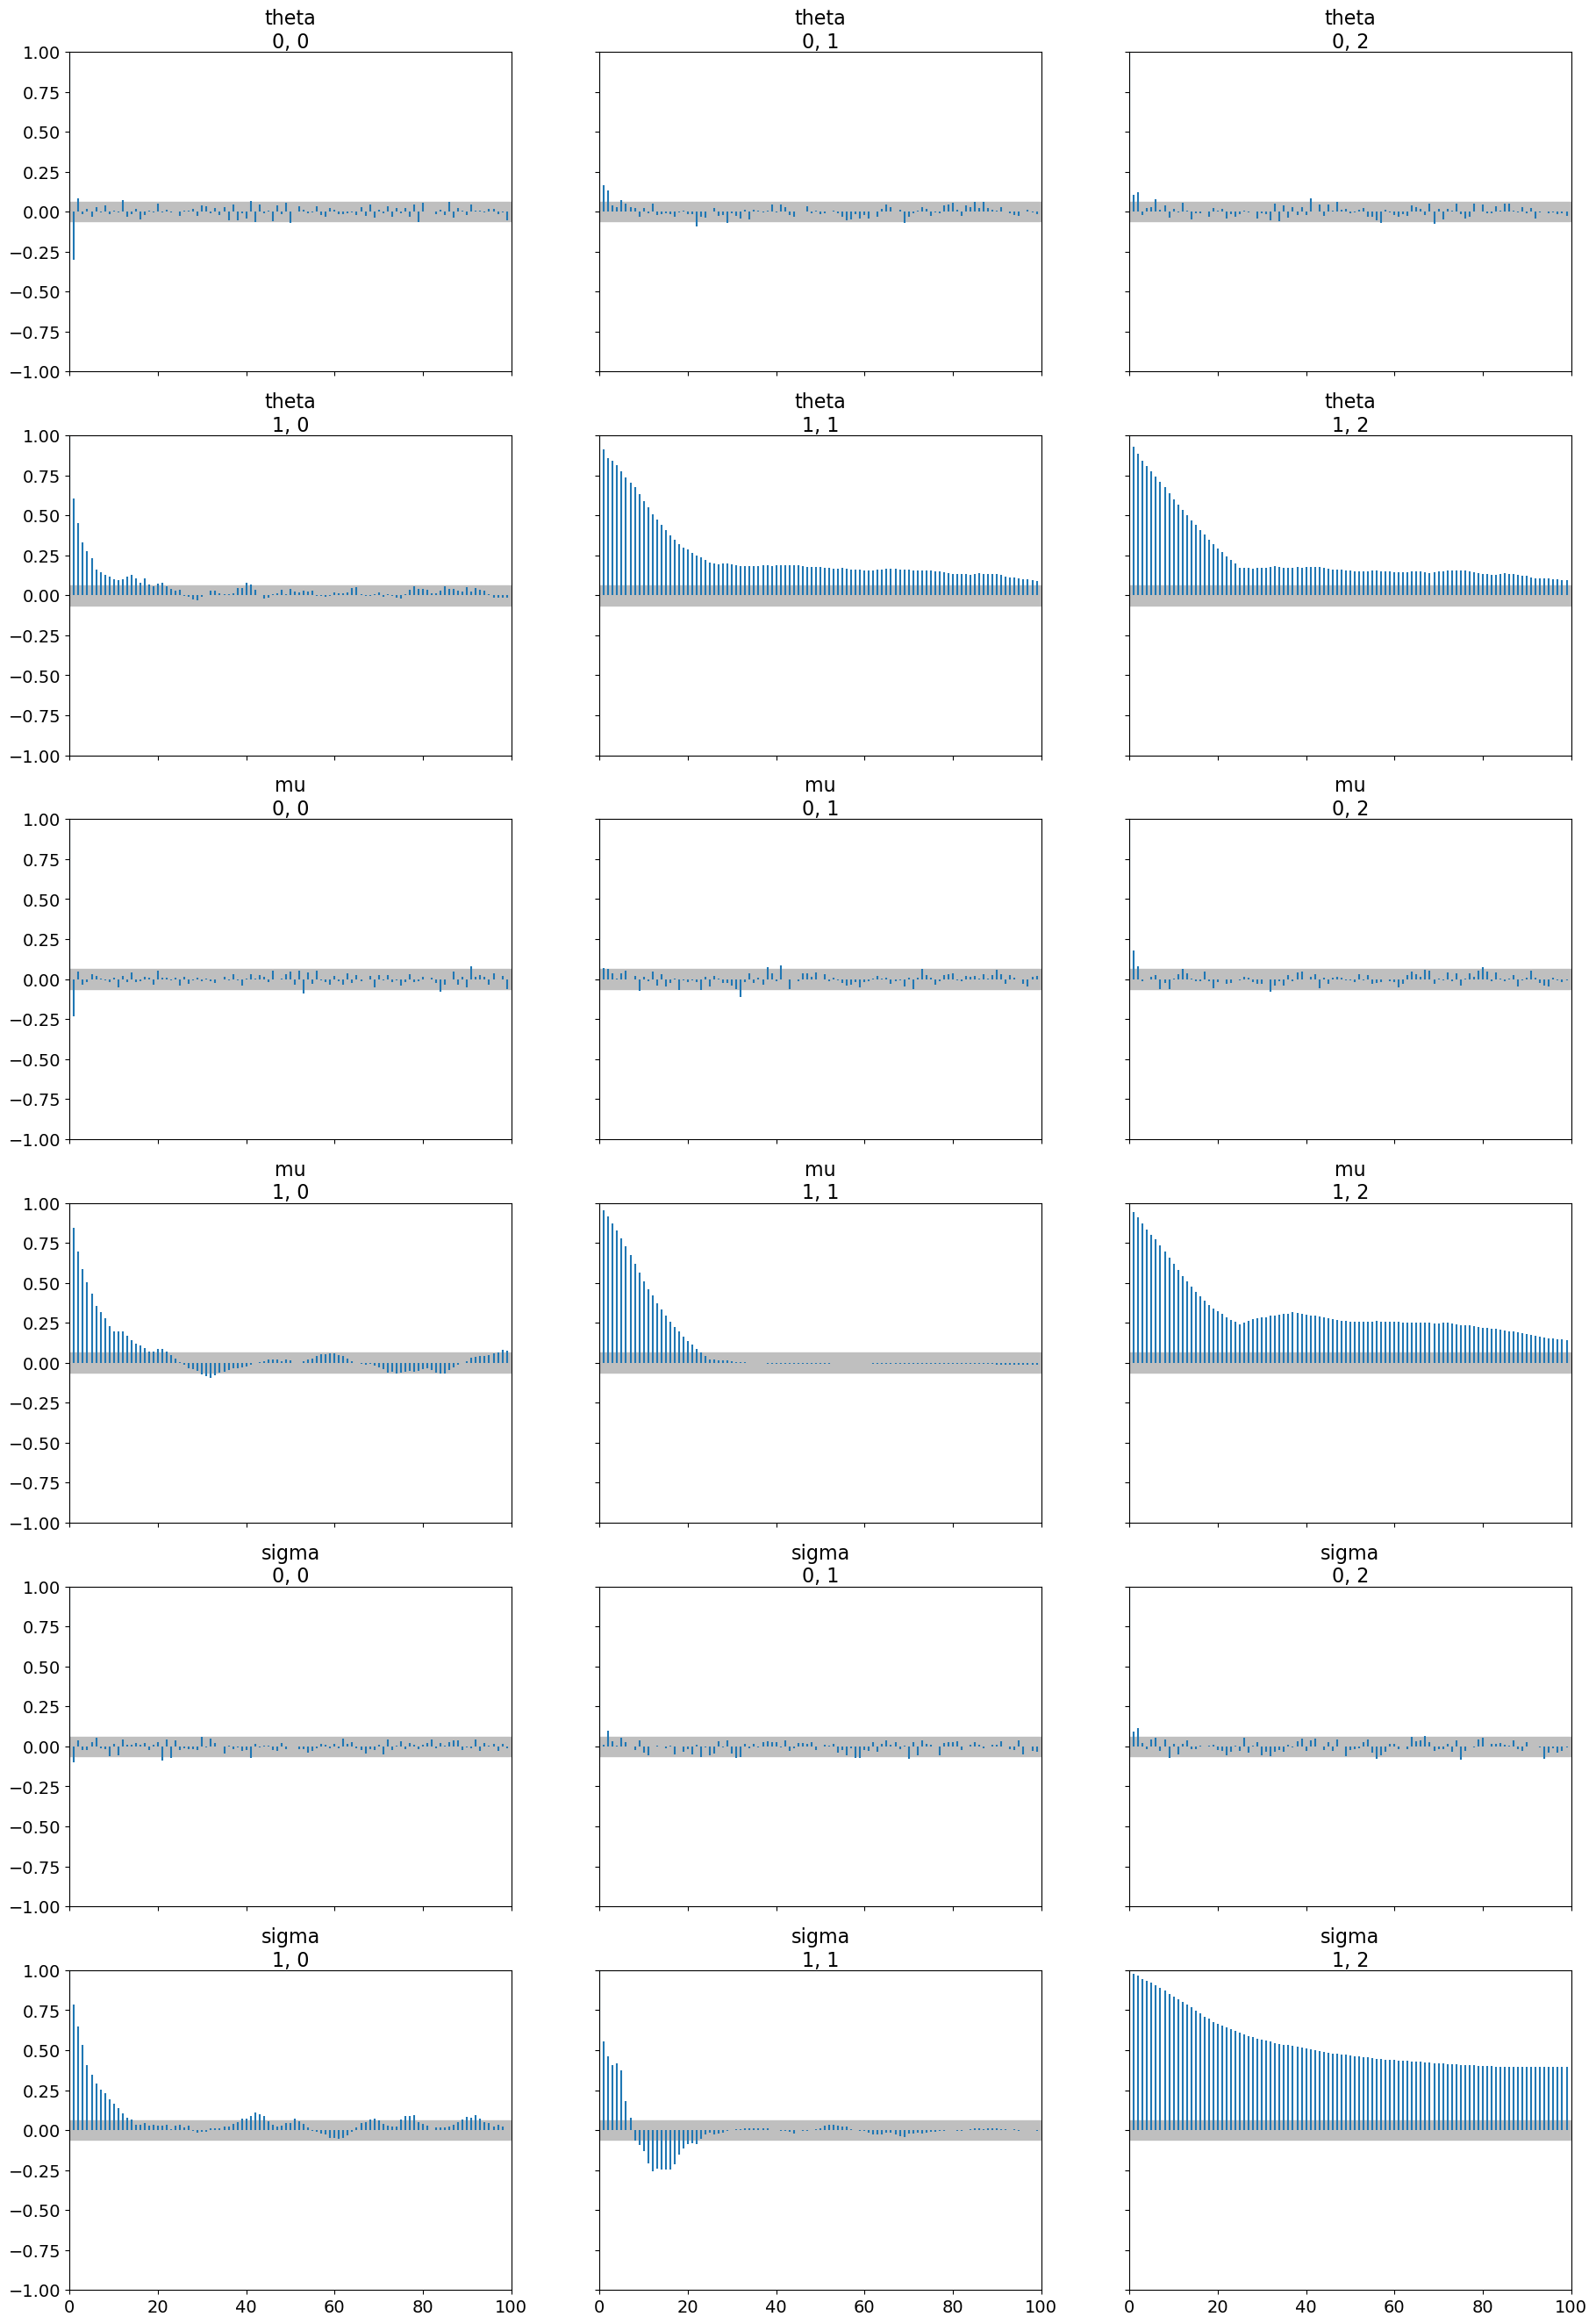

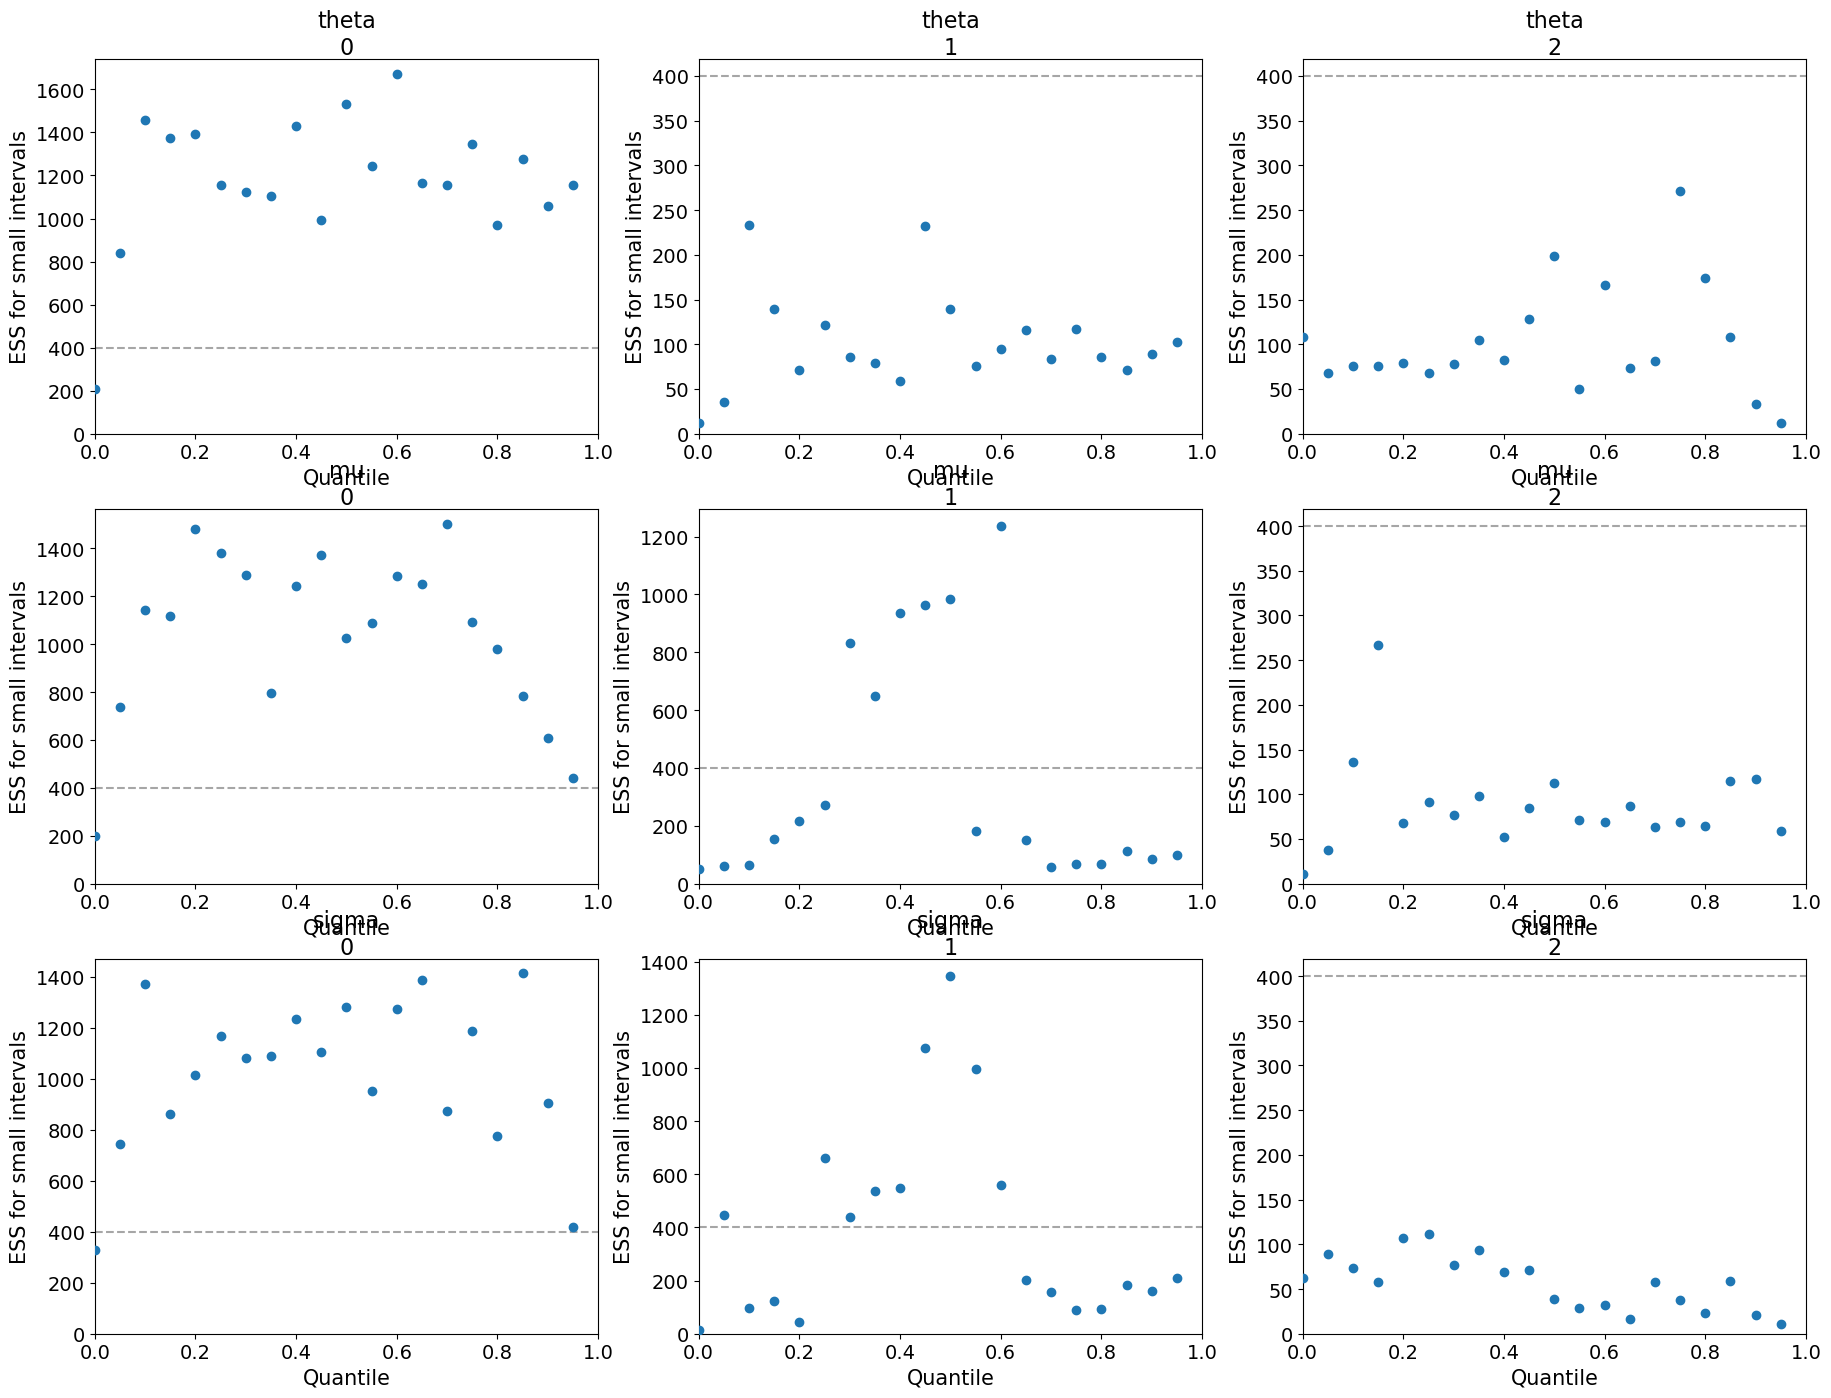

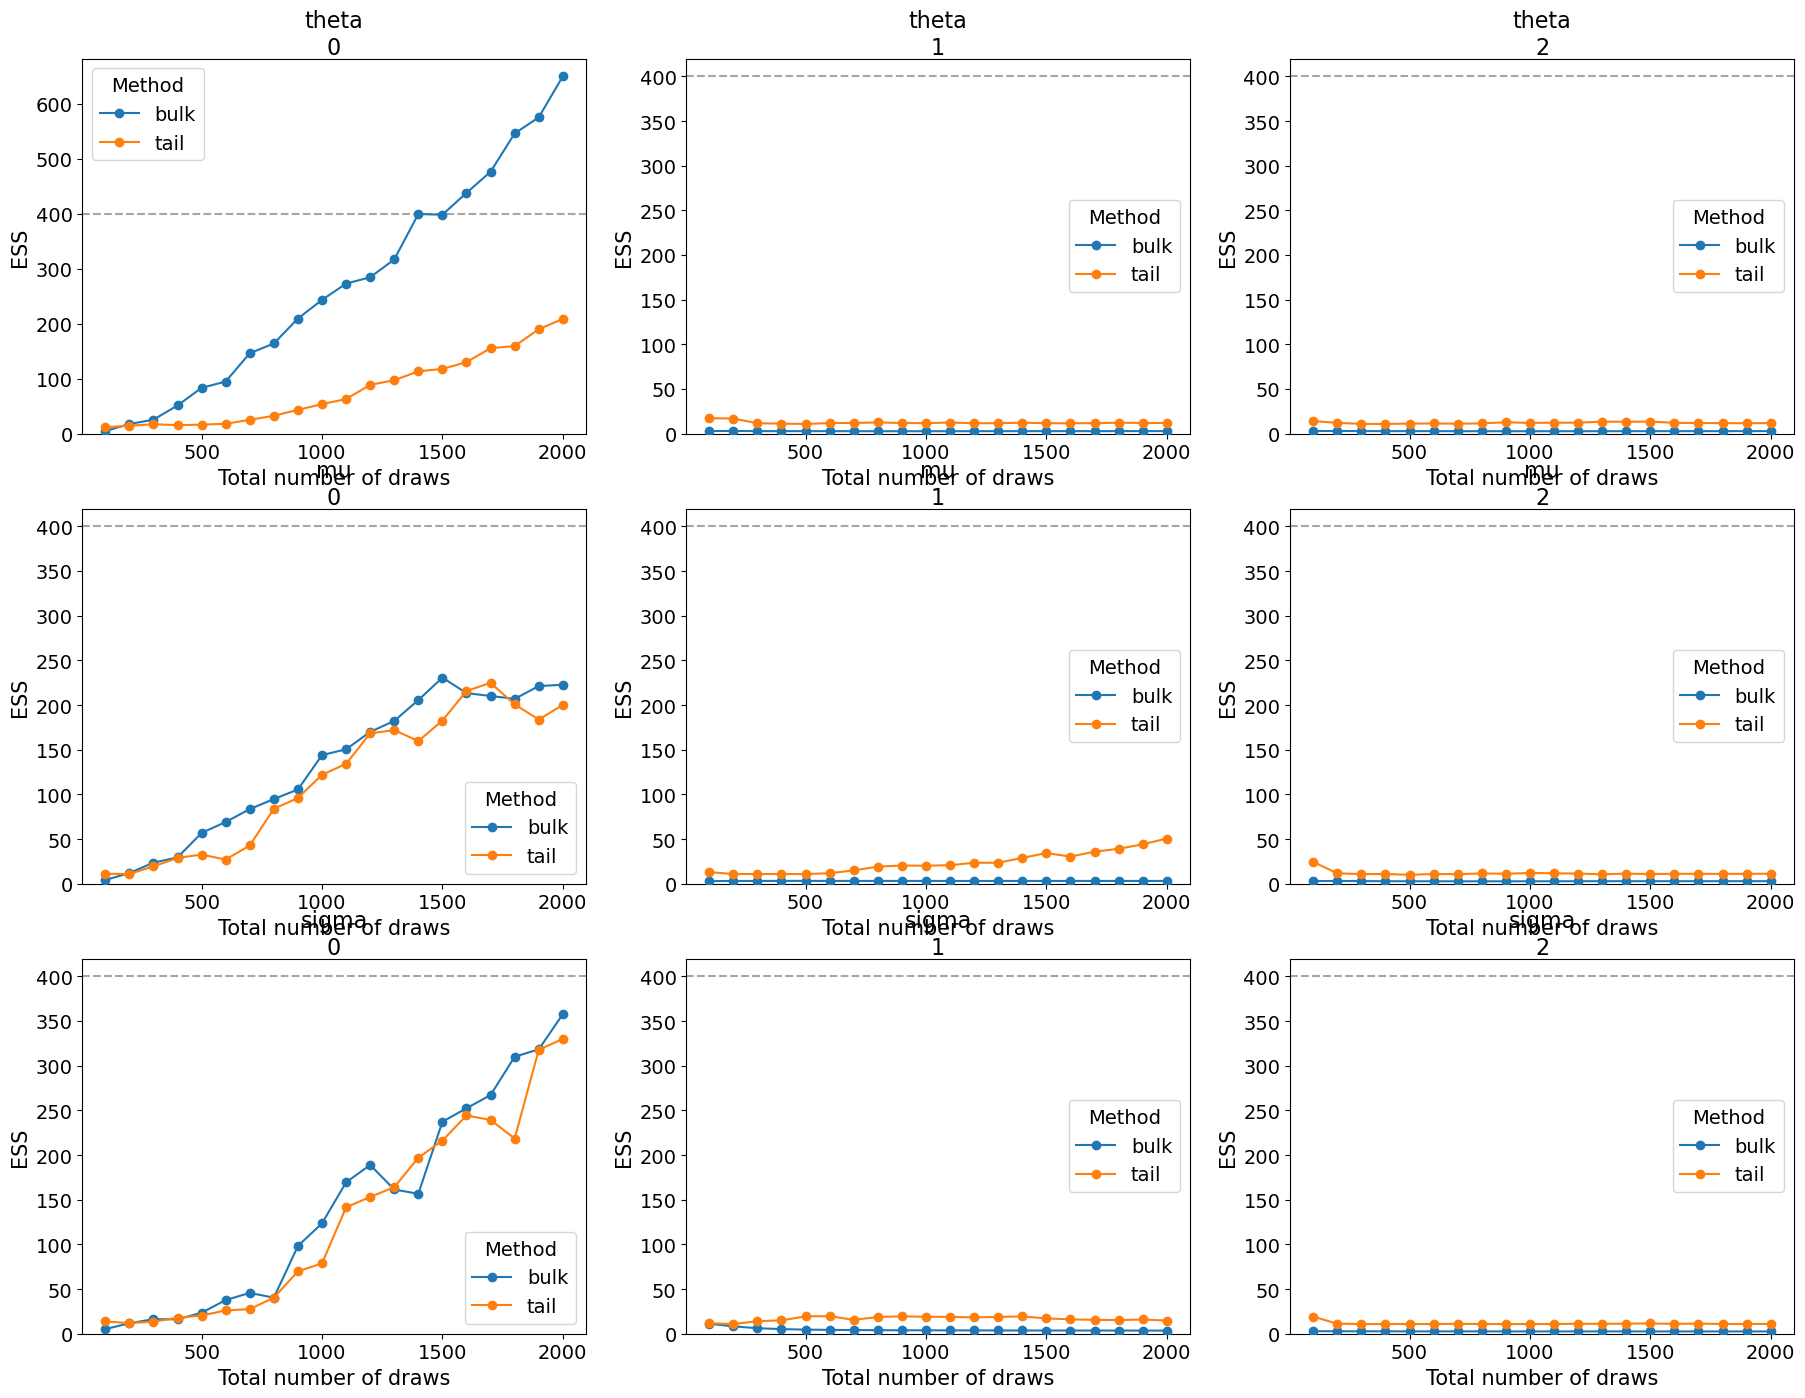

IS THE MODEL GOOD?


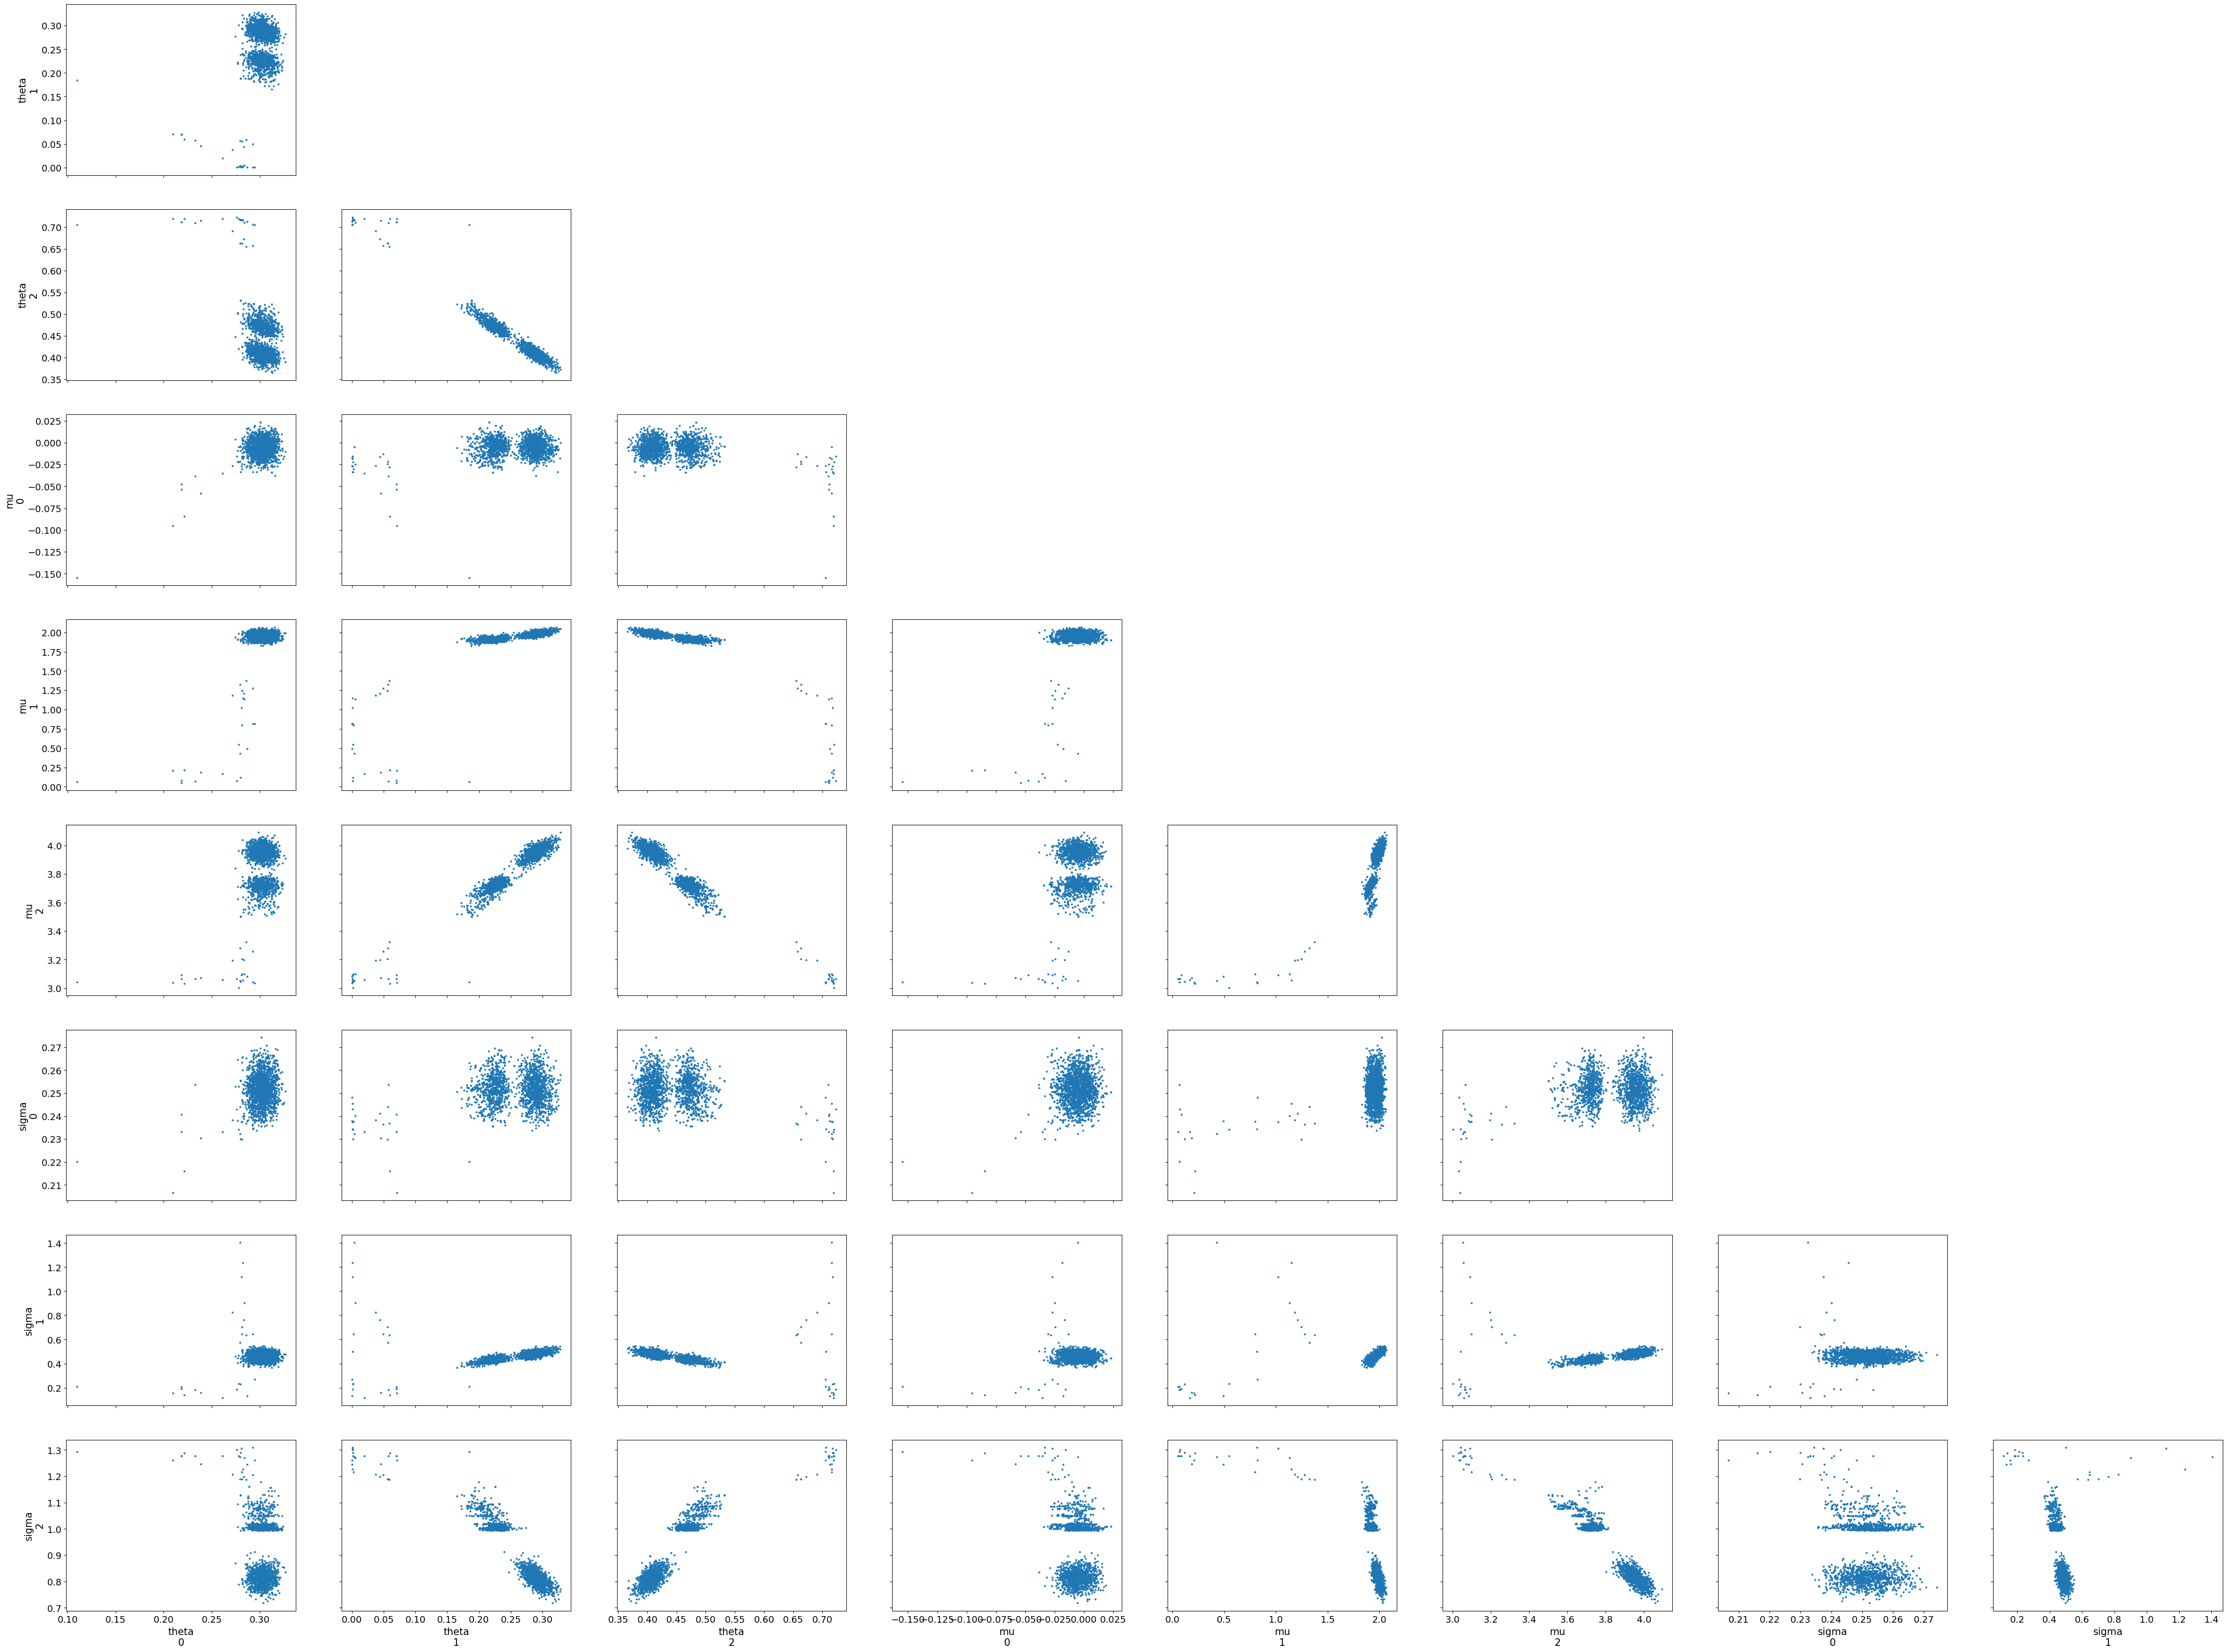

In [171]:
plot_stuff_about_model(idata, stan_data, fit)

# When things are not separated or less data

In [172]:
K = 3
thetas = [0.2, 0.3, 0.5]
mus = [0, 4, 8]
sigmas = [0.25, 0.5, 0.75]

In [173]:
stan_data = generate_data_from_mixture(thetas, mus, sigmas, K, N = 500)

(array([0.10741739, 0.25187525, 0.02592833, 0.        , 0.        ,
        0.0074081 , 0.03333643, 0.09630524, 0.24446715, 0.19261048,
        0.04815262, 0.00370405, 0.0074081 , 0.06667286, 0.12223358,
        0.22965096, 0.20372263, 0.14445786, 0.04444857, 0.02222429]),
 array([-0.66590897, -0.12595913,  0.41399071,  0.95394055,  1.49389039,
         2.03384023,  2.57379007,  3.11373991,  3.65368975,  4.19363959,
         4.73358943,  5.27353927,  5.81348911,  6.35343895,  6.89338879,
         7.43333863,  7.97328847,  8.51323831,  9.05318815,  9.59313799,
        10.13308784]),
 <BarContainer object of 20 artists>)

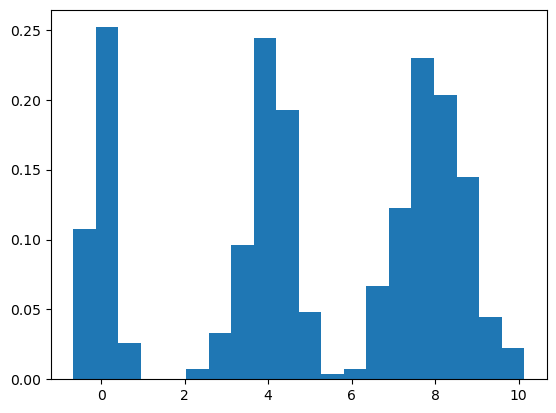

In [174]:
plt.hist(stan_data['y'], bins = 20, density = True)

### Let's fit the model

In [175]:
stan_folder = 'stan_code/'
stan_file = stan_folder + 'mixture_normals.stan'
with open(stan_file) as file:
    model_code = file.read()
print(model_code)

# From following url: https://mc-stan.org/docs/stan-users-guide/summing-out-the-responsibility-parameter.html

data {
  int<lower=1> K;          // number of mixture components
  int<lower=1> N;          // number of data points
  array[N] real y;         // observations
}
parameters {
  simplex[K] theta;          // mixing proportions
  ordered[K] mu;             // locations of mixture components
  vector<lower=0>[K] sigma;  // scales of mixture components
}
model {
  vector[K] log_theta = log(theta);  // cache log calculation
  sigma ~ lognormal(0, 3);
  mu ~ normal(0, 20);
  for (n in 1:N) {
    vector[K] lps = log_theta;
    for (k in 1:K) {
      lps[k] += normal_lpdf(y[n] | mu[k], sigma[k]);
    }
    target += log_sum_exp(lps);
  }
}


In [176]:
compiled_model = stan.build(model_code, data=stan_data, random_seed=1)

Building...



Building: found in cache, done.Messages from stanc:
Warning in '/tmp/httpstan_b_pxh092/model_3w6ohvzf.stan', line 1, column 0: Comments
    beginning with # are deprecated and this syntax will be removed in Stan
    2.32.0. Use // to begin line comments; this can be done automatically
    using the auto-format flag to stanc
Warning in '/tmp/httpstan_b_pxh092/model_3w6ohvzf.stan', line 16, column 17: Argument
    20 suggests there may be parameters that are not unit scale; consider
    rescaling with a multiplier (see manual section 22.12).
    provided, or the prior(s) depend on data variables. In the later case,
    this may be a false positive.


In [177]:
fit = compiled_model.sample(num_chains=2, num_warmup = 200, num_samples= 500)

Sampling:   0%
Sampling:   0% (1/1400)
Sampling:   0% (2/1400)
Sampling:   7% (101/1400)
Sampling:  50% (701/1400)
Sampling:  57% (800/1400)
Sampling:  64% (900/1400)
Sampling:  64% (901/1400)
Sampling:  71% (1000/1400)
Sampling:  79% (1100/1400)
Sampling:  86% (1200/1400)
Sampling:  93% (1300/1400)
Sampling: 100% (1400/1400)
Sampling: 100% (1400/1400), done.
Messages received during sampling:
  Gradient evaluation took 0.000461 seconds
  1000 transitions using 10 leapfrog steps per transition would take 4.61 seconds.
  Adjust your expectations accordingly!
  Informational Message: The current Metropolis proposal is about to be rejected because of the following issue:
  Exception: normal_lpdf: Location parameter is inf, but must be finite! (in '/tmp/httpstan_0lg_8dwv/model_3w6ohvzf.stan', line 20, column 6 to column 52)
  If this warning occurs sporadically, such as for highly constrained variable types like covariance matrices, then the sampler is fine,
  but if this warning occurs of

In [178]:
idata = az.from_pystan(posterior=fit, posterior_model=compiled_model
                            )

In [179]:
thetas

[0.2, 0.3, 0.5]

In [180]:
mus

[0, 4, 8]

In [181]:
sigmas

[0.25, 0.5, 0.75]

In [182]:
summary = az.summary(fit)
summary

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
theta[0],0.121,0.095,0.000,0.231,0.063,0.053,3.0,44.0,1.83
theta[1],0.257,0.089,0.094,0.375,0.058,0.050,3.0,52.0,1.83
theta[2],0.622,0.171,0.416,0.821,0.120,0.101,3.0,287.0,1.83
mu[0],-1.847,3.813,-11.130,0.081,1.244,0.909,3.0,55.0,1.78
mu[1],2.037,1.979,-0.016,4.083,1.388,1.172,3.0,70.0,1.83
mu[2],7.115,0.869,6.115,8.075,0.607,0.512,3.0,131.0,1.83
sigma[0],7.003,45.553,0.001,10.983,2.893,2.048,111.0,141.0,1.39
sigma[1],0.399,0.160,0.173,0.609,0.110,0.092,3.0,74.0,1.83
sigma[2],1.447,0.665,0.719,2.227,0.465,0.392,3.0,124.0,1.83


CONVERGENCE CHECKS


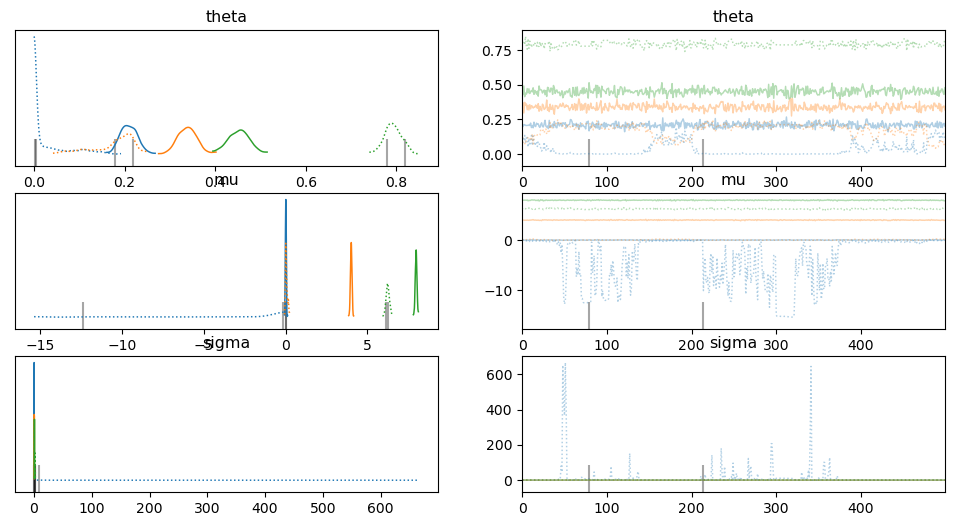

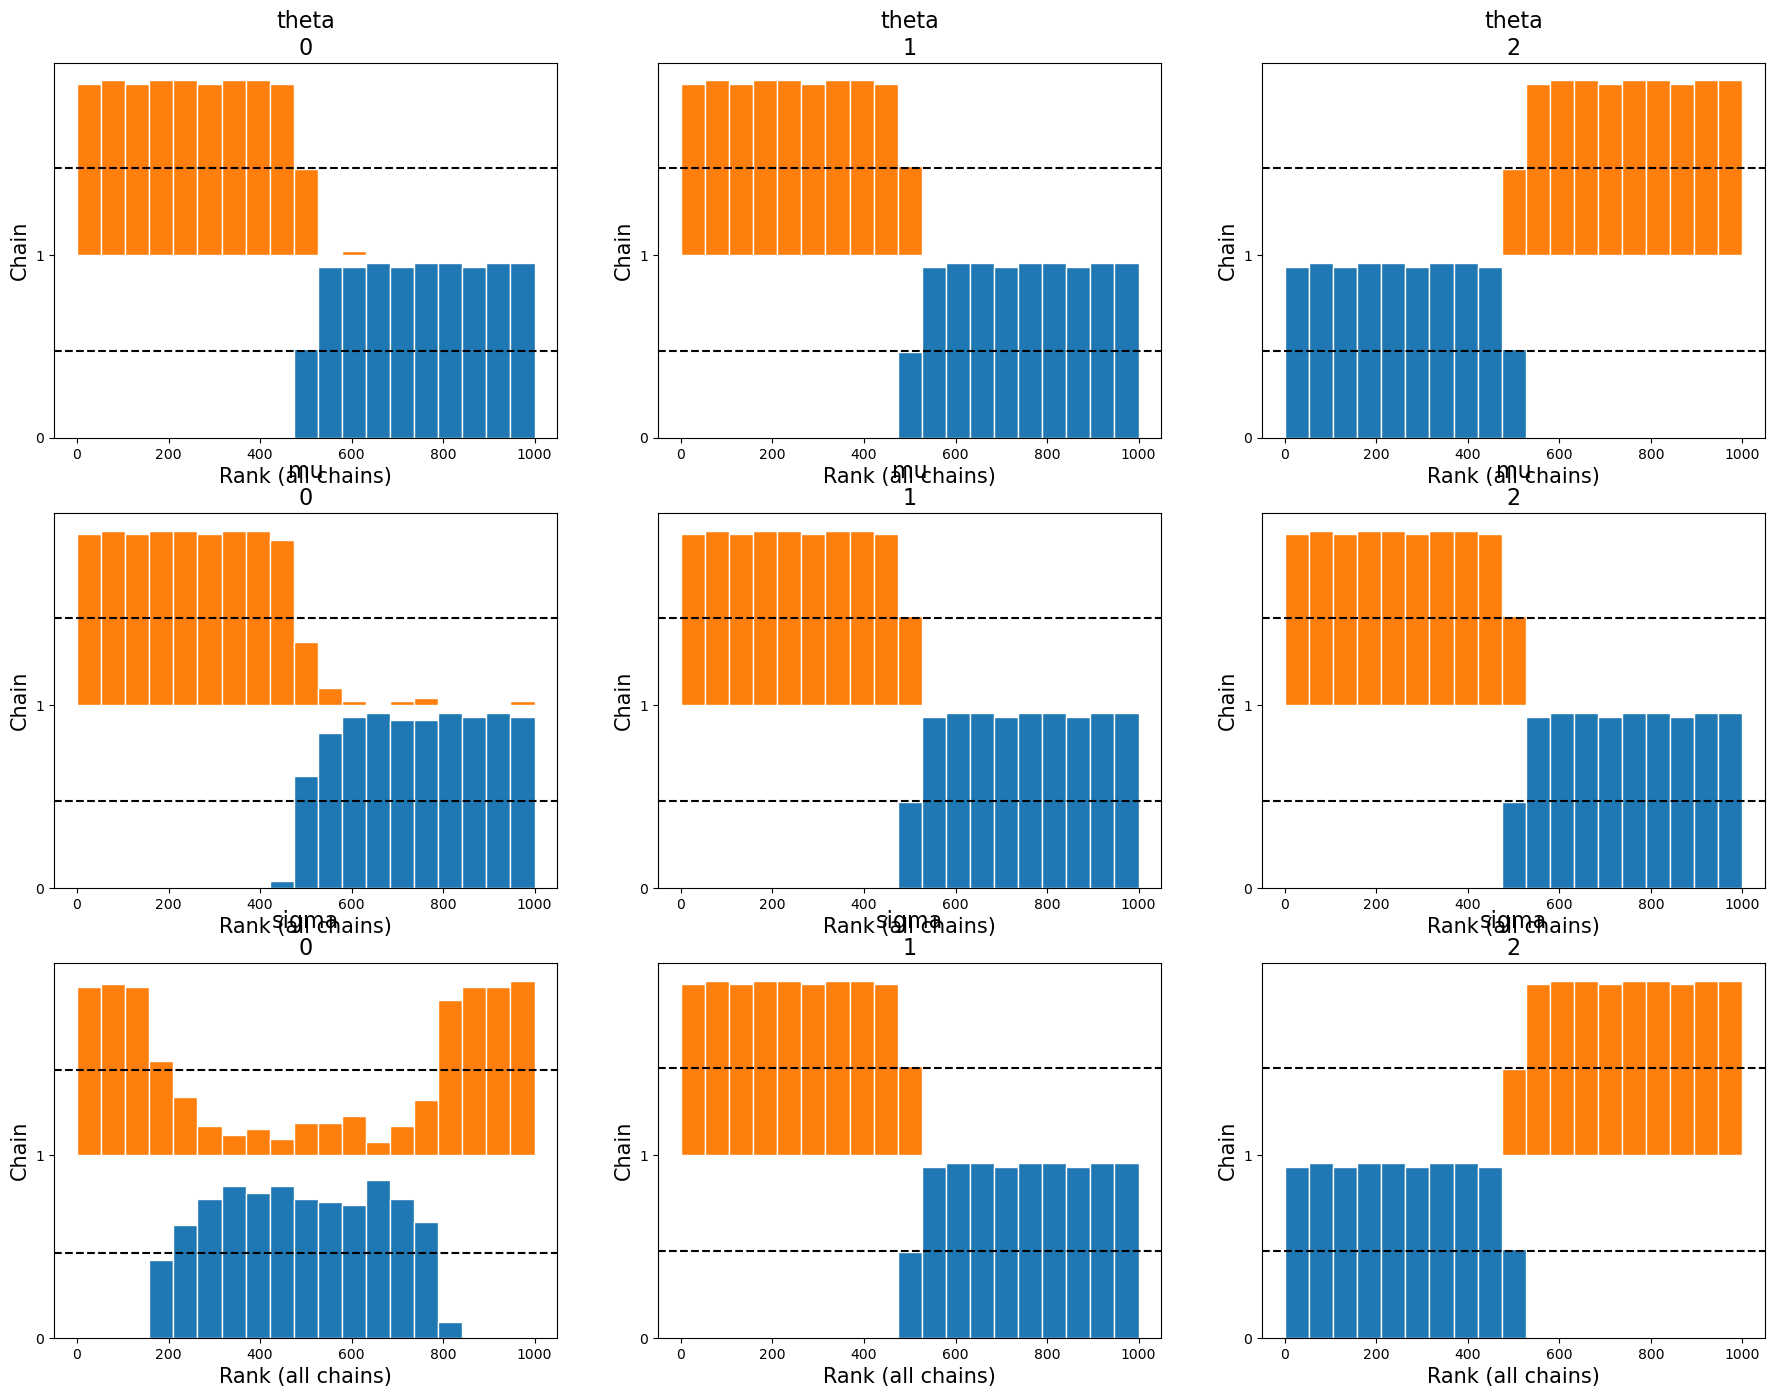

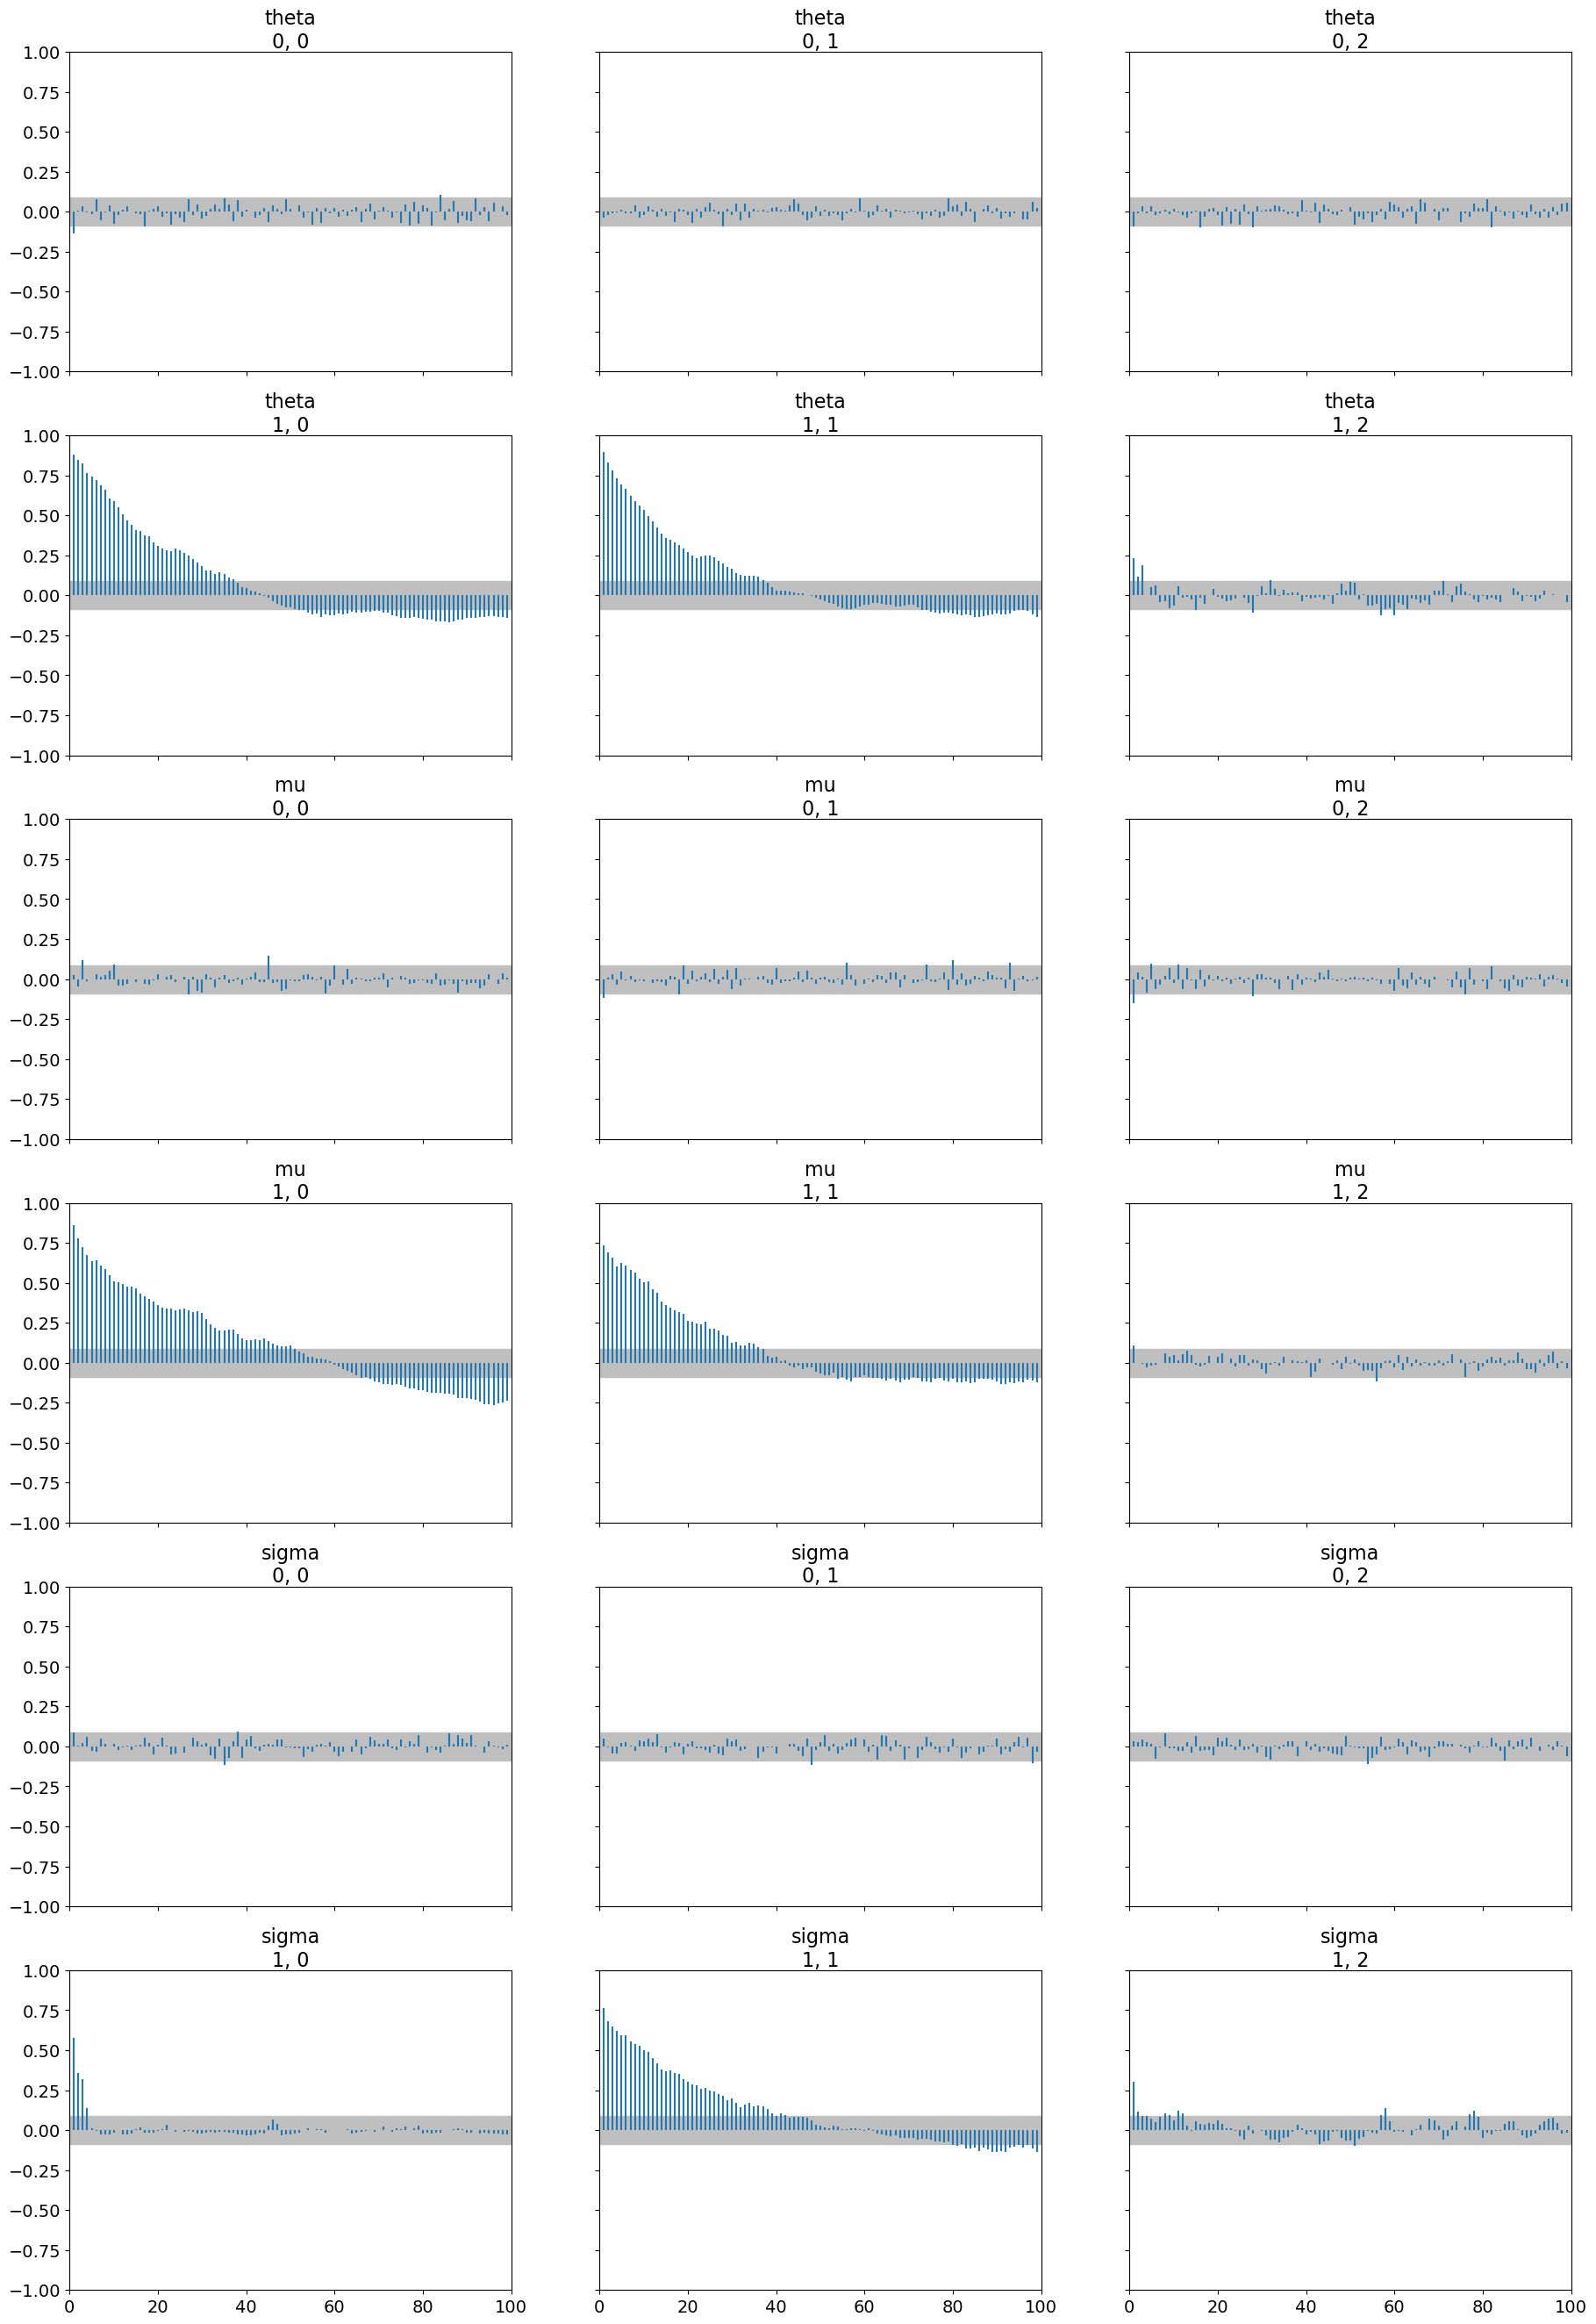

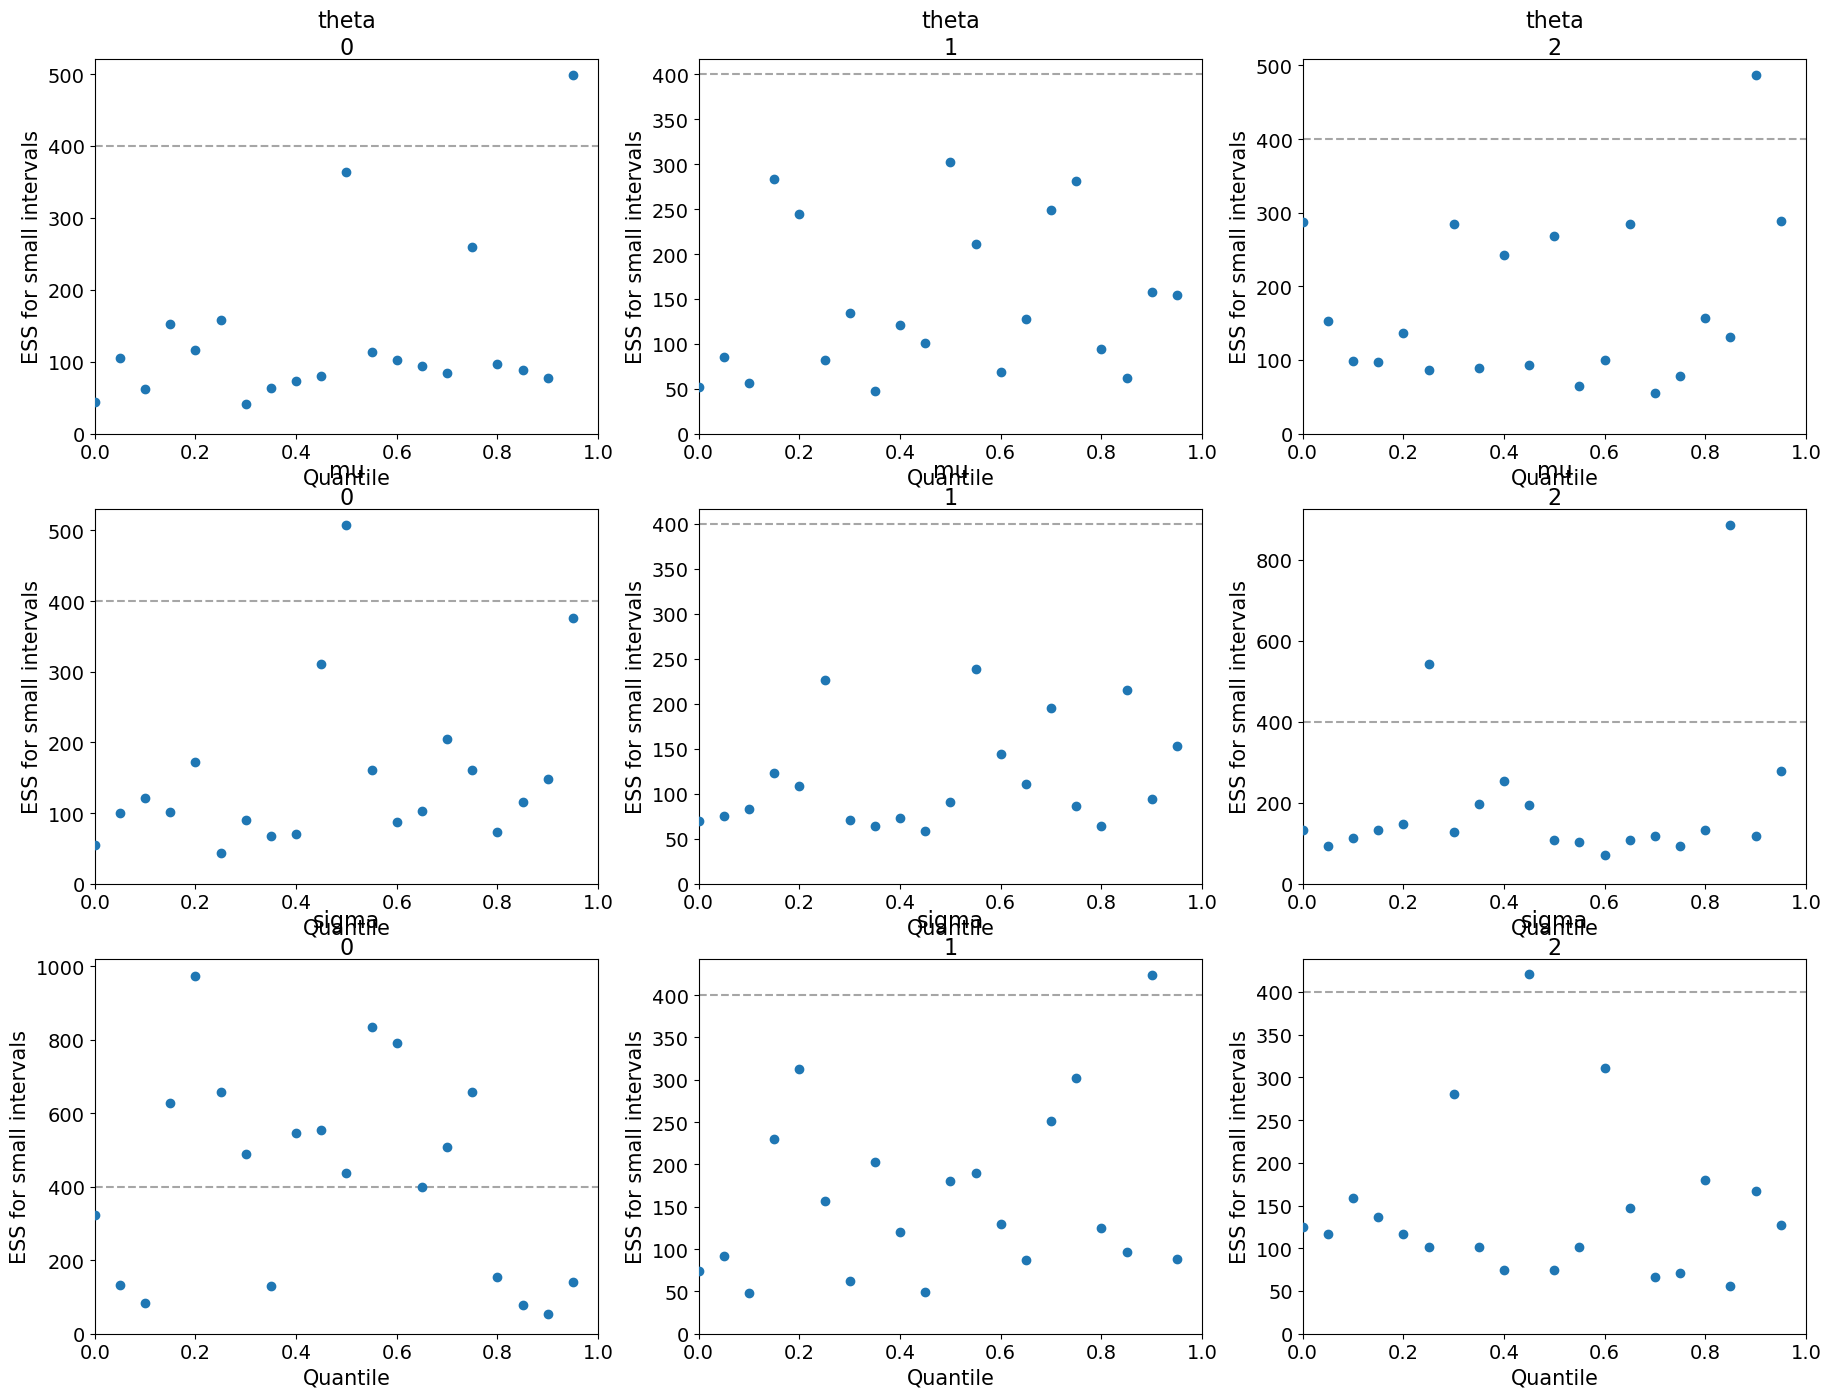

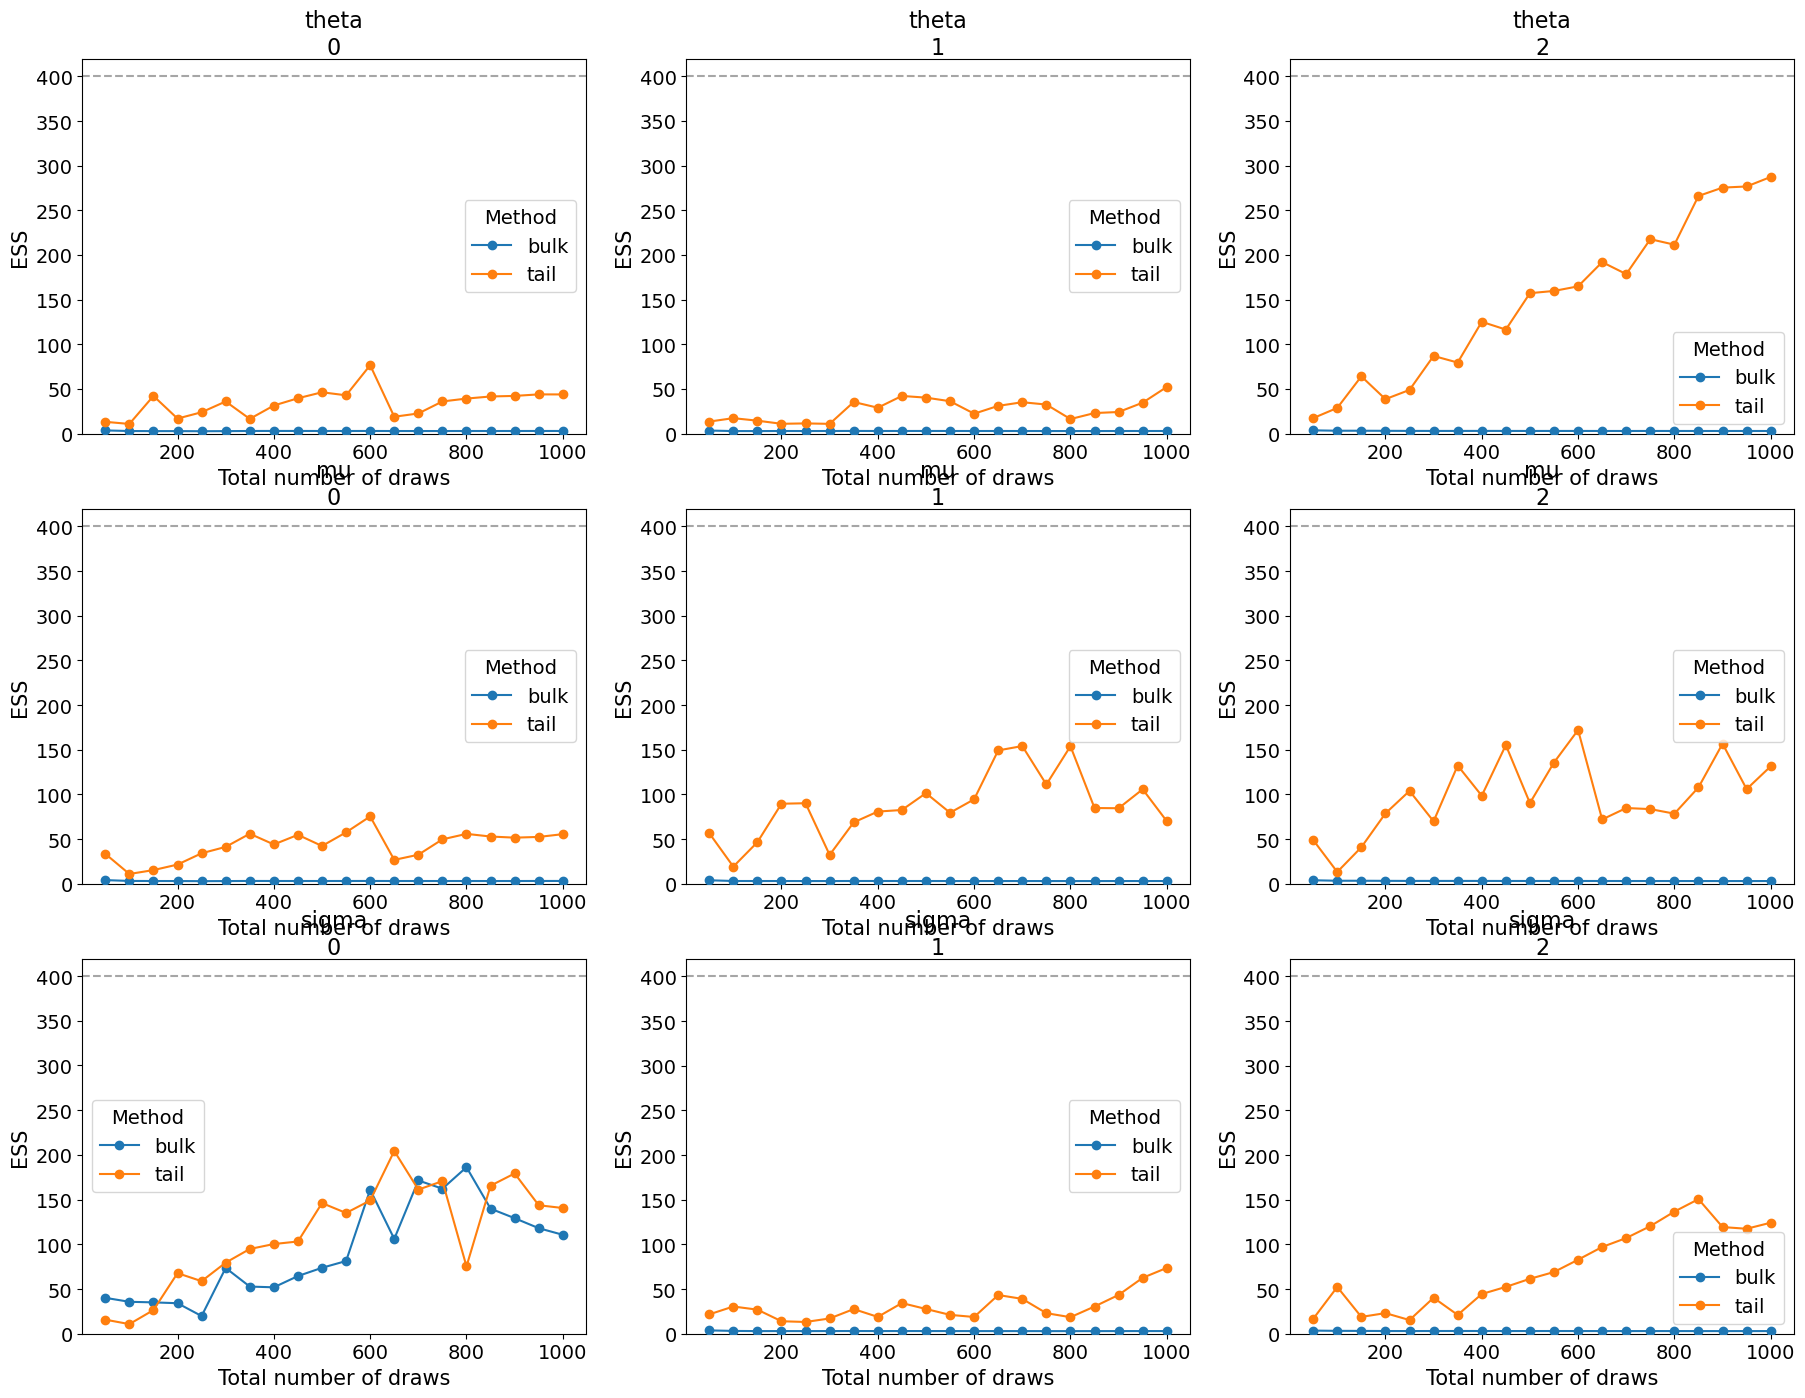

IS THE MODEL GOOD?


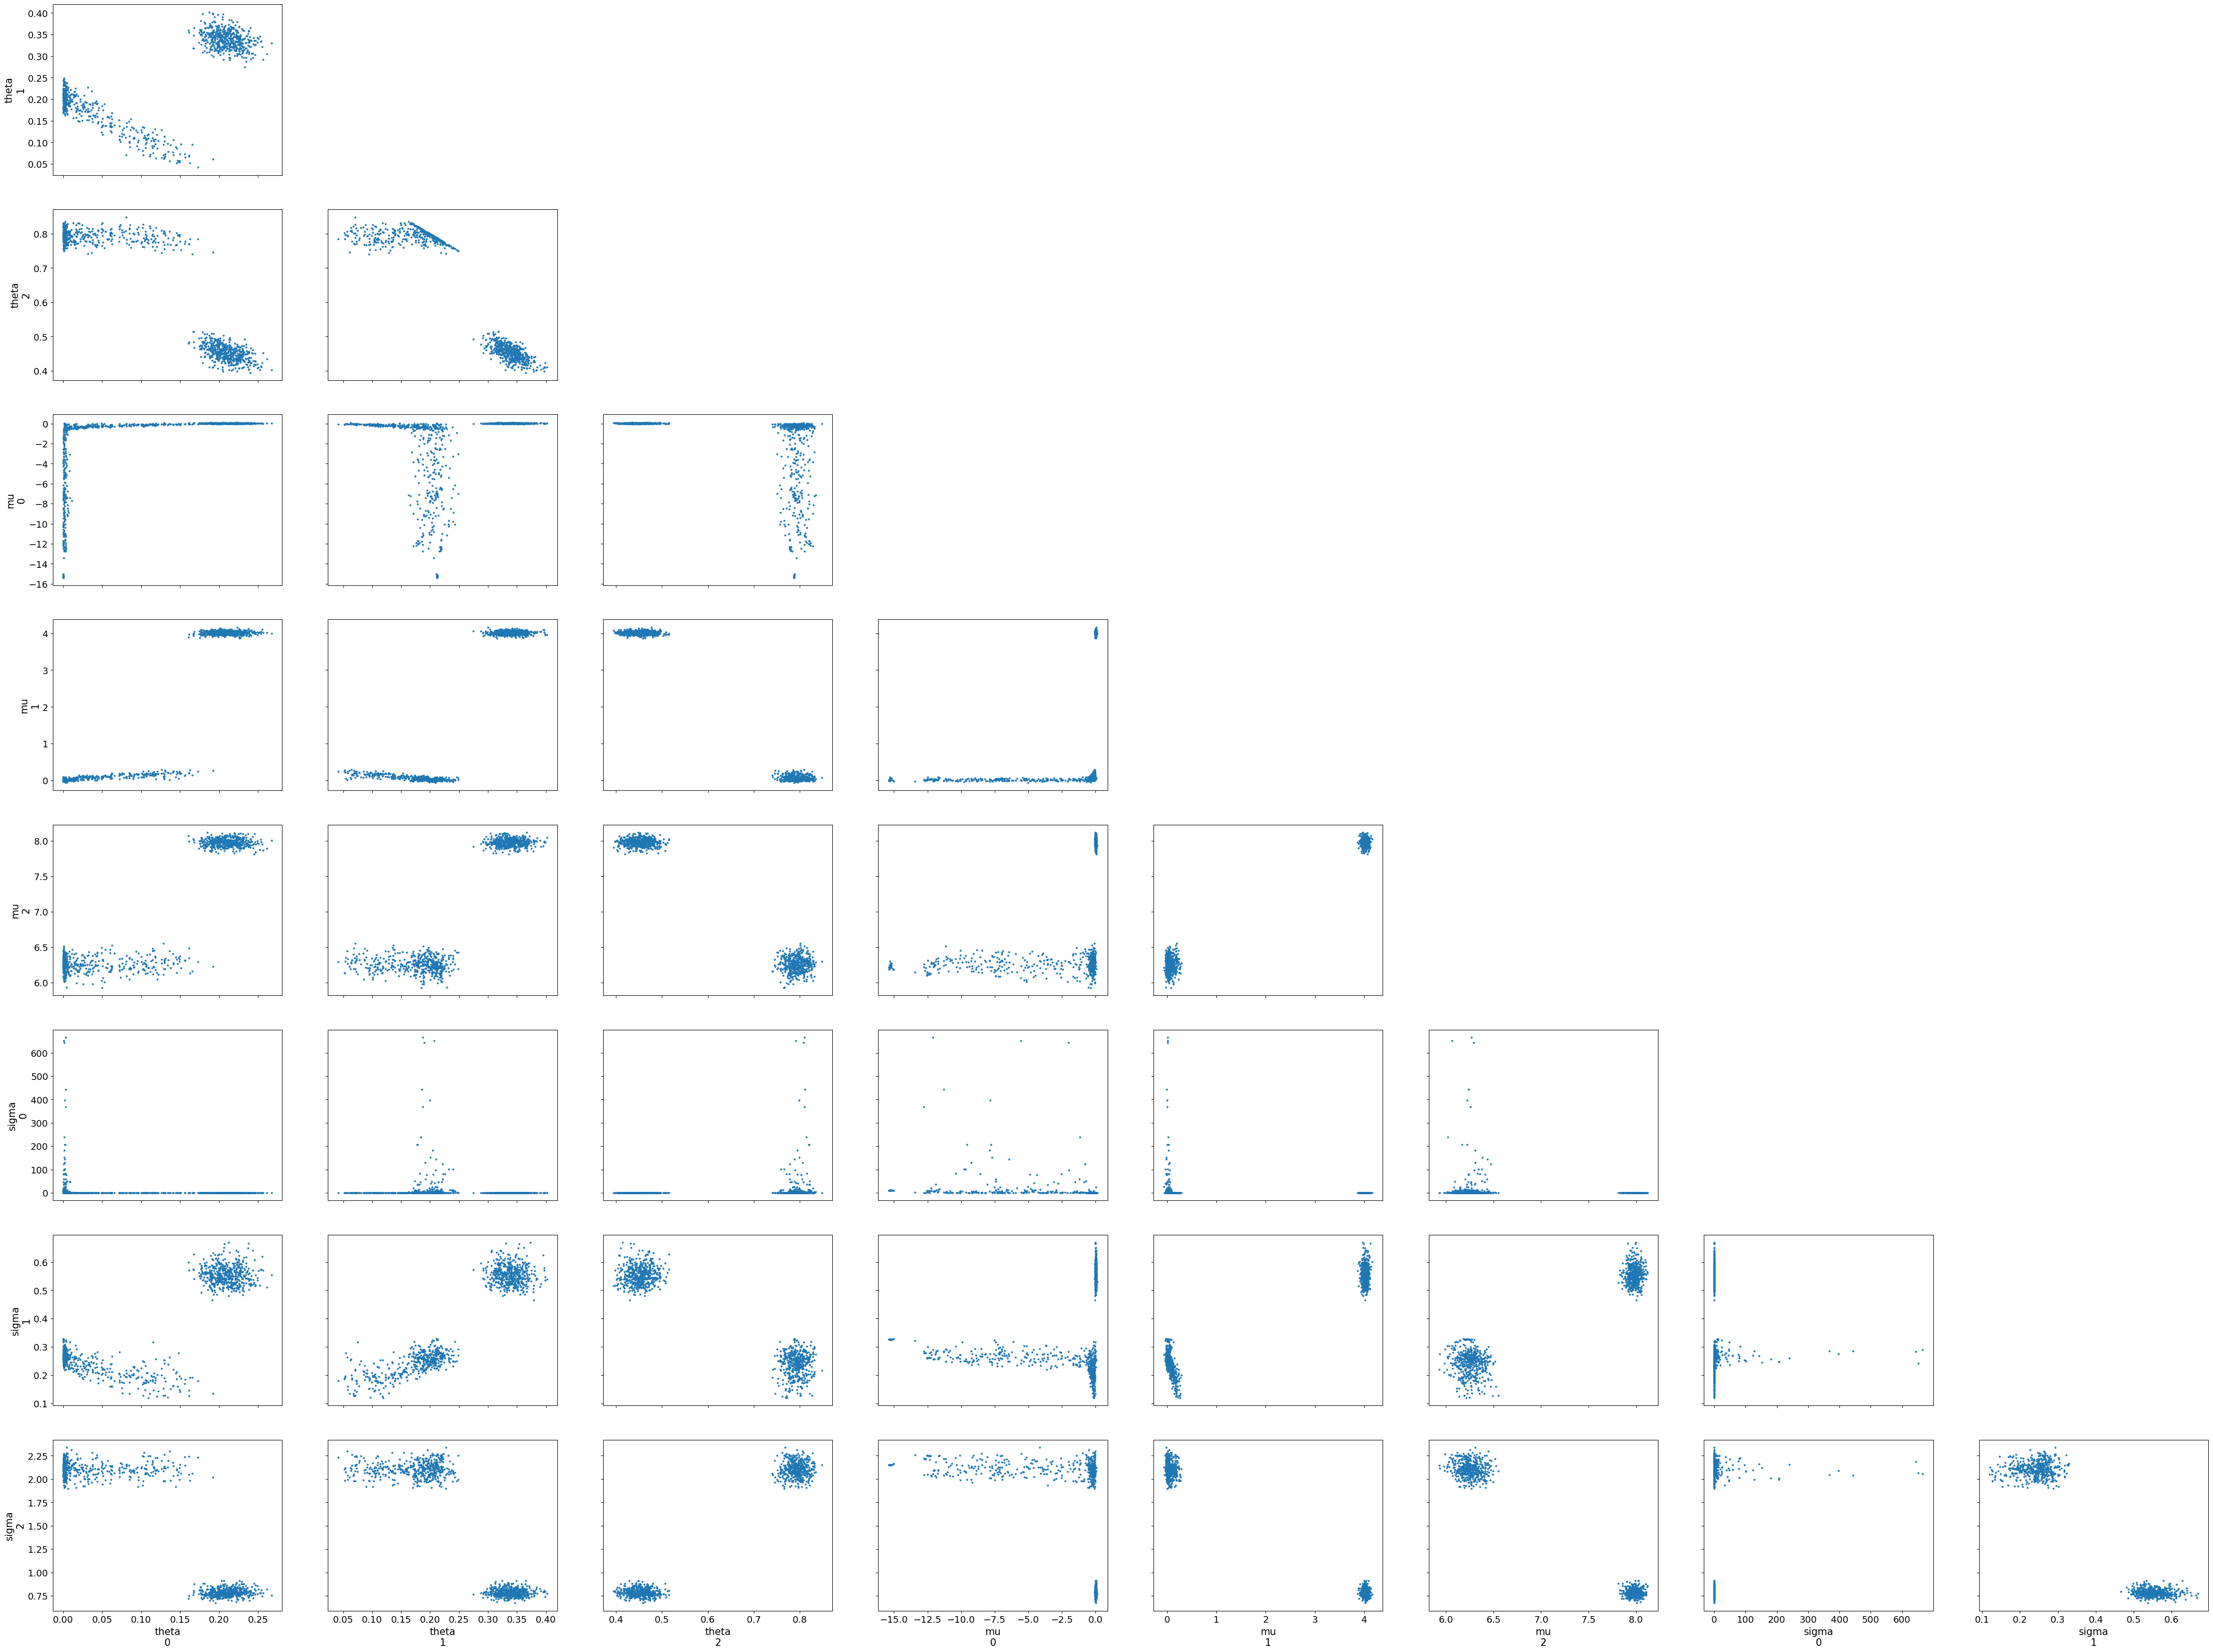

In [183]:
plot_stuff_about_model(idata, stan_data, fit)